In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
class DuelingBandits:
    def __init__(self, num_arms, win_matrix, best_arm, time_horizon=1e10):
        self.best_arm = best_arm
        self.total_pulls = 0
        self.history = []
        self.time_horizon = time_horizon
        self.regret = 0
        self.num_arms = num_arms
        self.win_matrix = win_matrix  # Win matrix. win_matrix[i][j] is the probability that arm i beats arm j
        self.arms = {i:{'history':[], 'num_pulls':0, 'num_wins':0} for i in range(num_arms)}  # Set of arms
    
    def pull_arms(self, arm_1, arm_2):
        """Simulate pulling the selected arm and receiving a reward."""
        # Updates Globals:
        self.total_pulls += 1

        # Simulate pulling the arms
        if (np.random.binomial(1, self.win_matrix[arm_1, arm_2]+0.5)):
            winning_arm = arm_1
            losing_arm = arm_2
        else: 
            winning_arm = arm_2
            losing_arm = arm_1
        
        # Updates the number of pulls for each arm
        self.arms[arm_1]['num_pulls'] += 1
        self.arms[arm_2]['num_pulls'] += 1

        # Updates the number of wins for each arm
        self.arms[winning_arm]['num_wins'] += 1
        self.arms[losing_arm]['num_wins'] += 0

        # Add to the history of each of the arms:
        self.arms[arm_1]['history'].append({"winner": winning_arm, "loser": losing_arm, "round": self.total_pulls})
        self.arms[arm_2]['history'].append({"winner": winning_arm, "loser": losing_arm, "round": self.total_pulls})

        # Update the regret
        self.regret += 0.5 * (self.win_matrix[self.best_arm, losing_arm] + self.win_matrix[self.best_arm, winning_arm])

        # Add to the global history
        self.history.append({"winner": winning_arm, "loser": losing_arm, "round": self.total_pulls, "regret": self.regret})
        
        return winning_arm
    

In [3]:
class sbm():
	def __init__(self, n_arms, alpha=1):
		self.alpha = alpha
		self.num_arms = n_arms

	def reset(self):
		self.averages = np.ones(self.num_arms)*math.inf
		self.pulls = np.ones(self.num_arms)
		self.time = 1

	def random_argmax(self, array):
		max_indices = np.where(array == array.max())[0]
		selected_index = np.random.choice(max_indices)
		return selected_index

	def advance(self):
		bound = self.averages + np.sqrt((self.alpha+2)*np.log(self.time)/(2*self.pulls))
		choice = self.random_argmax(bound)
		return choice

	def feedback(self, arm, reward):
		self.time += 1
		
		if self.averages[arm] == math.inf:
			self.averages[arm] = reward
		else:
			self.averages[arm] = (self.averages[arm]*self.pulls[arm] + reward)/(self.pulls[arm]+1)
		
		self.pulls[arm] += 1

In [4]:
class Doubler():
	def __init__(self, bandit : DuelingBandits):

		self.bandit = bandit
		self.num_arms = bandit.num_arms
		self.sbm = sbm(bandit.num_arms)

		self.l = np.random.randint(self.num_arms, size=1)
		self.i, self.t = 1, 1

		self.time_horizon = bandit.time_horizon

	def run(self):
		while self.t < self.time_horizon:
						
			self.sbm.reset()
			new_l = set()

			for j in range(2**self.i):
				xt = np.random.choice(self.l)
				yt = self.sbm.advance()
				new_l.add(yt)
				winning_arm = self.bandit.pull_arms(xt, yt)

				if xt == winning_arm:
					self.sbm.feedback(yt, 0)
					self.sbm.feedback(xt, 1)
				else:
					self.sbm.feedback(yt, 1)
					self.sbm.feedback(xt, 0)

				self.t += 1

				if self.t >= self.time_horizon:
					break

			self.l = np.array(list(new_l))
			self.i += 1

		return

In [5]:
class MultiSBM():
	def __init__(self, bandit : DuelingBandits):

		self.bandit = bandit
		self.num_arms = bandit.num_arms
		self.sbms = [sbm(bandit.num_arms) for i in range(self.num_arms)]

		self.t = 1

		self.time_horizon = bandit.time_horizon

	def run(self):
		for cursbm in self.sbms:
			cursbm.reset()
		yt_1 = np.random.choice(range(1, self.num_arms))
		while self.t < self.time_horizon:
	
			xt = yt_1
			cur_sbm = self.sbms[xt]
			yt = cur_sbm.advance()

			
			winning_arm = self.bandit.pull_arms(xt, yt)

			if xt == winning_arm:
				cur_sbm.feedback(yt, 0)
				cur_sbm.feedback(xt, 1)
			else:
				cur_sbm.feedback(yt, 1)
				cur_sbm.feedback(xt, 0)
				
				self.t += 1

				if self.t >= self.time_horizon:
					break
		return 

In [6]:
class Sparring():
	def __init__(self, bandit : DuelingBandits):

		self.bandit = bandit
		self.num_arms = bandit.num_arms
		self.sl = sbm(bandit.num_arms)
		self.sr = sbm(bandit.num_arms)

		self.t = 1

		self.time_horizon = bandit.time_horizon

	def run(self):
		# Resetting the SBMs
		self.sl.reset()
		self.sr.reset()
		
		while self.t < self.time_horizon:
			xt = self.sl.advance()
			yt = self.sr.advance()
			
			winning_arm = self.bandit.pull_arms(xt, yt)

			if xt == winning_arm:
				self.sl.feedback(xt, 1)
				self.sr.feedback(yt, 0)
			else:
				self.sl.feedback(yt, 1)
				self.sr.feedback(xt, 0)

			self.t += 1

			if self.t >= self.time_horizon:
				break
		return 


In [7]:
class IF1():
	def __init__(self, bandit : DuelingBandits):
		self.bandit = bandit
		self.num_arms = bandit.num_arms
		self.t = 1
		self.time_horizon = bandit.time_horizon
		self.wins = np.zeros((self.num_arms, self.num_arms))
		self.P_hat = np.ones((self.num_arms, self.num_arms))*1/2
		self.n_rounds = np.zeros((self.num_arms, self.num_arms))
		self.c_hat = np.empty((self.num_arms, self.num_arms))
		self.delta = 1/(self.time_horizon*self.num_arms**2)
		self.T_hat = 0 # total comparisons made

	def update(self, b_1, b_2, res):
		self.n_rounds[b_1, b_2] = self.n_rounds[b_1, b_2] + 1
		self.n_rounds[b_2, b_1] = self.n_rounds[b_2, b_1] + 1
		self.wins[b_1, b_2] += res
		self.wins[b_2, b_1] += (1-res)
		self.P_hat[b_1, b_2] = self.wins[b_1, b_2]/self.n_rounds[b_1, b_2]
		self.P_hat[b_2, b_1] = self.wins[b_2, b_1]/self.n_rounds[b_2, b_1]
		self.c_hat[b_1, b_2] = math.sqrt(math.log(1/self.delta)/self.n_rounds[b_1, b_2])
		self.c_hat[b_2, b_1] = math.sqrt(math.log(1/self.delta)/self.n_rounds[b_2, b_1])
	
	def run(self):
		#def IF1(T, K, bandit):
		# runs interleaved filter 1 over K dueling-bandits with time horizon T

		W = np.arange(0, self.num_arms)
		b_hat = np.random.choice(self.num_arms)
		W = np.array(W[~np.isin(W, b_hat)])

		while len(W) > 0:
			for b in W:
				res = self.bandit.pull_arms(b_hat, b)
				if res == b_hat:
					won = 1
				else:
					won = 0
				self.T_hat += 1
				self.update(b_hat, b, won)
			b_to_remove = np.where(np.logical_and(self.P_hat[b_hat, :] > 1/2, 
				(self.P_hat[b_hat, :] - self.c_hat[b_hat, :]) > 1/2))
			W = np.array(W[~np.isin(W, b_to_remove)])
			b_win = np.where(np.logical_and(self.P_hat[b_hat, :] < 1/2, 
				(self.P_hat[b_hat, :] + self.c_hat[b_hat, :]) < 1/2))[0]
			if len(b_win) > 0:
				b_hat = b_win[np.random.choice(len(b_win))]
				W = np.array(W[(~(np.isin(W, b_hat)))])
				self.wins = np.zeros((self.num_arms, self.num_arms))
				self.P_hat = np.ones((self.num_arms, self.num_arms))*1/2
				self.n_rounds = np.zeros((self.num_arms, self.num_arms))
				self.c_hat = np.empty((self.num_arms, self.num_arms))
		return (b_hat, self.T_hat)


In [8]:
class IF2():
	def __init__(self, bandit : DuelingBandits):
		self.bandit = bandit
		self.num_arms = bandit.num_arms
		self.t = 1
		self.time_horizon = bandit.time_horizon
		self.wins = np.zeros((self.num_arms, self.num_arms))
		self.P_hat = np.ones((self.num_arms, self.num_arms))*1/2
		self.n_rounds = np.zeros((self.num_arms, self.num_arms))
		self.c_hat = np.empty((self.num_arms, self.num_arms))
		self.delta = 1/(self.time_horizon*self.num_arms**2)
		self.T_hat = 0 # total comparisons made

	def update(self, b_1, b_2, res):
		self.n_rounds[b_1, b_2] = self.n_rounds[b_1, b_2] + 1
		self.n_rounds[b_2, b_1] = self.n_rounds[b_2, b_1] + 1
		self.wins[b_1, b_2] += res
		self.wins[b_2, b_1] += (1-res)
		self.P_hat[b_1, b_2] = self.wins[b_1, b_2]/self.n_rounds[b_1, b_2]
		self.P_hat[b_2, b_1] = self.wins[b_2, b_1]/self.n_rounds[b_2, b_1]
		self.c_hat[b_1, b_2] = math.sqrt(math.log(1/self.delta)/self.n_rounds[b_1, b_2])
		self.c_hat[b_2, b_1] = math.sqrt(math.log(1/self.delta)/self.n_rounds[b_2, b_1])
	
	def run(self):
		#def IF1(T, K, bandit):
		# runs interleaved filter 1 over K dueling-bandits with time horizon T

		W = np.arange(0, self.num_arms)
		b_hat = np.random.choice(self.num_arms)
		W = np.array(W[~np.isin(W, b_hat)])

		while len(W) > 0:
			for b in W:
				res = self.bandit.pull_arms(b_hat, b)
				if res == b_hat:
					won = 1
				else:
					won = 0
				self.T_hat += 1
				self.update(b_hat, b, won)
			b_to_remove = np.where(np.logical_and(self.P_hat[b_hat, :] > 1/2, 
				(self.P_hat[b_hat, :] - self.c_hat[b_hat, :]) > 1/2))
			W = np.array(W[~np.isin(W, b_to_remove)])
			b_win = np.where(np.logical_and(self.P_hat[b_hat, :] < 1/2, 
				(self.P_hat[b_hat, :] + self.c_hat[b_hat, :]) < 1/2))[0]
			if len(b_win) > 0:
				# Pruning Stage
				b_to_remove = np.where(self.P_hat[b_hat, :] > 1/2)
				W = np.array(W[(~(np.isin(W, b_to_remove)))])
				
				b_hat = b_win[np.random.choice(len(b_win))]
				W = np.array(W[(~(np.isin(W, b_hat)))])
				self.wins = np.zeros((self.num_arms, self.num_arms))
				self.P_hat = np.ones((self.num_arms, self.num_arms))*1/2
				self.n_rounds = np.zeros((self.num_arms, self.num_arms))
				self.c_hat = np.empty((self.num_arms, self.num_arms))
		return (b_hat, self.T_hat)


In [9]:
class btmb():
	def __init__(self, bandit : DuelingBandits):
		self.bandit = bandit
		self.num_arms = bandit.num_arms
		self.t = 1
		self.time_horizon = bandit.time_horizon
		self.delta = 1/(2*self.num_arms*self.time_horizon)
		self.arm_histories = {i:{'history':[]} for i in range(self.num_arms)}
		self.num_comp = np.zeros(self.num_arms)
		self.num_wins = np.zeros(self.num_arms)
		self.P_hat = np.ones(self.num_arms)*1/2
    	# choose random bandit to start with out of those with fewest pulls
		self.c_star = 1
		
	def confidence(self, n):
		return math.sqrt(1/n * math.log(1/self.delta)) if n > 1 else 1
	
	def update(self, b_1, b_2, res):
		self.n_rounds[b_1, b_2] = self.n_rounds[b_1, b_2] + 1
		self.n_rounds[b_2, b_1] = self.n_rounds[b_2, b_1] + 1
		self.wins[b_1, b_2] += res
		self.wins[b_2, b_1] += (1-res)
		self.P_hat[b_1, b_2] = self.wins[b_1, b_2]/self.n_rounds[b_1, b_2]
		self.P_hat[b_2, b_1] = self.wins[b_2, b_1]/self.n_rounds[b_2, b_1]
		self.c_hat[b_1, b_2] = math.sqrt(math.log(1/self.delta)/self.n_rounds[b_1, b_2])
		self.c_hat[b_2, b_1] = math.sqrt(math.log(1/self.delta)/self.n_rounds[b_2, b_1])
	
	def run(self):
		W = np.arange(0, self.num_arms)
		while len(W) > 1 and self.t < self.time_horizon:
			b = W[np.random.choice(np.flatnonzero(self.num_comp[W] == np.min(self.num_comp[W])))]
			b_prime = np.random.choice(W[(~(np.isin(W, b)))])
			res = self.bandit.pull_arms(b, b_prime)
			if res == b:
				losing_arm = b_prime
			else:
				losing_arm = b
			self.arm_histories[b]['history'].append({"winner": res, "loser": losing_arm})
			self.num_comp[b] += 1
			self.c_star = self.confidence(self.num_comp[b])
			
			if b == res:
				self.num_wins[b] += 1
				self.P_hat[b] = self.num_wins[b]/self.num_comp[b] 
			
			self.t += 1
			if np.min(self.P_hat[W] + self.c_star) <= np.max(self.P_hat[W] - self.c_star):
				b_prime = W[np.random.choice(np.flatnonzero(self.P_hat[W] == np.min(self.P_hat[W])))]
				W = np.array(W[(~(np.isin(W, b_prime)))])
				# remove comparisons with b_prime from num_wins, num_comp
				for b in W:
					losers = np.array([i['loser'] for i in self.arm_histories[b]['history']])
					num_beat_b_prime = np.sum(losers == b_prime)
					
					winners = [i['winner'] for i in self.arm_histories[b]['history']]
					num_lost_to_b_prime = np.sum(winners == b_prime)

					self.num_wins[b] = self.num_wins[b] - num_beat_b_prime
					self.num_comp[b] = self.num_comp[b] - (num_beat_b_prime + num_lost_to_b_prime)
		return W[np.argmax(self.P_hat[W])]

In [10]:
def log_link(mu_i, mu_j):
    return 1/(1+math.exp(mu_j-mu_i))

In [11]:
def build_exp_2(K, link_func=log_link):
    mu = np.random.normal(size=K)
    best_arm = np.argmax(mu)
    win_matrix = np.zeros((K, K))
    for i in range(K):
        for j in range(i+1, K):
            win_matrix[i, j] = link_func(mu[i], mu[j]) - 0.5
            win_matrix[j, i] = link_func(mu[j], mu[i]) - 0.5
    return K, win_matrix, best_arm

In [12]:
K, win_matrix, best_arm = build_exp_2(5)

In [13]:
def ret_db():
    return DuelingBandits(K, win_matrix, best_arm, time_horizon=1e5)

In [14]:
def get_algorithm_regret_v_time(alg):
    alg.run()
    return list(map(lambda x: x['regret'], alg.bandit.history))

In [15]:
algorithms = [IF1(ret_db()), IF2(ret_db()), btmb(ret_db()), Doubler(ret_db()), MultiSBM(ret_db()), Sparring(ret_db())]

In [16]:
algorithm_names = ["IF1", "IF2", "BTMB", "Doubler", "MultiSBM", "Sparring"]

In [17]:
win_matrix

array([[ 0.        , -0.01472467,  0.09730572,  0.41226094,  0.33287594],
       [ 0.01472467,  0.        ,  0.11139198,  0.41686349,  0.34091661],
       [-0.09730572, -0.11139198,  0.        ,  0.37515276,  0.27063441],
       [-0.41226094, -0.41686349, -0.37515276,  0.        , -0.17599148],
       [-0.33287594, -0.34091661, -0.27063441,  0.17599148,  0.        ]])

In [18]:
to_test = 5
algorithms[to_test].run()
for i in range(K):
    print(algorithms[to_test].bandit.arms[i]['num_pulls'])

TypeError: sbm.random_argmax() takes 1 positional argument but 2 were given

In [ ]:
winners = [i["winner"] for i in algorithms[to_test].bandit.history]
losers = [i["loser"] for i in algorithms[to_test].bandit.history]
diff = np.where(np.array(winners) != np.array(losers))[0]

In [ ]:
diff

array([], dtype=int64)

In [ ]:
results = list(map(get_algorithm_regret_v_time, algorithms))

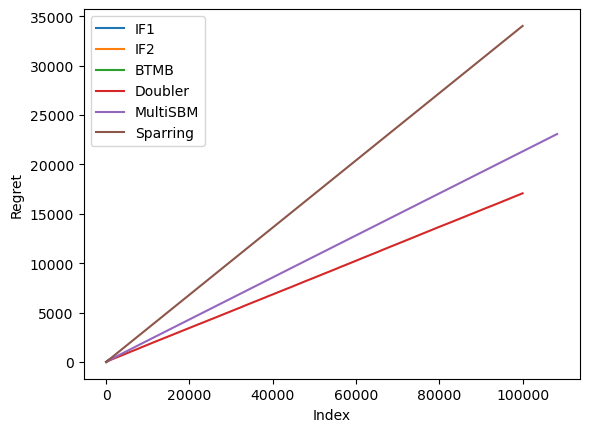

In [ ]:
for i in range(len(results)):
    index = np.arange(len(results[i]))
    plt.plot(index, results[i], label=algorithm_names[i])

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Regret')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Defining a strategy:
class Strategy:
    def __init__(self, arm, budget_ini, budget_rem, num_arms, time_horizon):
        self.arm = arm
        self.num_arms = num_arms
        self.time_horizon = time_horizon
        self.budget_ini = budget_ini
        self.budget_rem = budget_rem
        self.num_pulls = 0

    def bribe(self, history, curTime):

        return
